# Hybrid Model - Train

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
import glob
import sys
import random
import time
import scipy
import keras
from keras.optimizers import  Adam
from random import shuffle
import sys
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import frequency_spatial_network as fsnet  
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

/home/roberto/Documents/virtualenv/venv04/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Train Set 
train_path = "/media/roberto/DATA/GDrive/MR-Data/Normative-Raw-Data/Train/*.npy"
kspace_files_train = np.asarray(glob.glob(train_path))

# Validation set
val_path = "/media/roberto/DATA/GDrive/MR-Data/Normative-Raw-Data/Val/*.npy"
kspace_files_val = np.asarray(glob.glob(val_path))

indexes = np.arange(kspace_files_train.size,dtype = int)
np.random.shuffle(indexes)
kspace_files_train = kspace_files_train[indexes]


print kspace_files_train[-1]
print len(kspace_files_train)
print 
print kspace_files_val[-1]
print len(kspace_files_val)

/media/roberto/DATA/GDrive/MR-Data/Normative-Raw-Data/Train/e14292s3_P85504.7.npy
25

/media/roberto/DATA/GDrive/MR-Data/Normative-Raw-Data/Val/e14553s5_P44544.7.npy
10


Undersampling: 0.822937011719
Mask type: bool


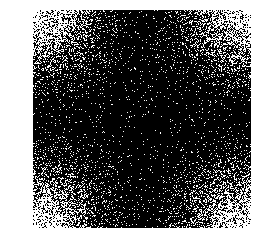

In [3]:
under_rate = '20'
imshape = (256,256)
norm = np.sqrt(imshape[0]*imshape[1])
nchannels = 2 #complex data real + imag

# undersampling patterns - uncentred k-space
var_sampling_mask = np.load("../Data/sampling_mask_" + under_rate + "perc.npy")

print "Undersampling:", 1.0*var_sampling_mask.sum()/var_sampling_mask.size
print "Mask type:",  var_sampling_mask.dtype
plt.figure()
plt.imshow(~var_sampling_mask,cmap = "gray")
plt.axis("off")
plt.show()

## Load Train Data

In [4]:
# Get number of samples
ntrain = 0
for ii in xrange(len(kspace_files_train)):
    ntrain += np.load(kspace_files_train[ii]).shape[0]

# Load train data    
rec_train = np.zeros((ntrain,imshape[0],imshape[1],2))
kspace_train = np.zeros((ntrain,imshape[0],imshape[1],2))
aux_counter = 0
for ii in xrange(len(kspace_files_train)):
     aux_kspace = np.load(kspace_files_train[ii])/norm
     aux = aux_kspace.shape[0]   
     aux2 = np.fft.ifft2(aux_kspace[:,:,:,0]+1j*aux_kspace[:,:,:,1])
     rec_train[aux_counter:aux_counter+aux,:,:,0] = aux2.real
     rec_train[aux_counter:aux_counter+aux,:,:,1] = aux2.imag
     kspace_train[aux_counter:aux_counter+aux,:,:,0] = aux_kspace[:,:,:,0]
     kspace_train[aux_counter:aux_counter+aux,:,:,1] = aux_kspace[:,:,:,1]
     aux_counter+=aux

# Shuffle training    
indexes = np.arange(rec_train.shape[0],dtype = int)
np.random.shuffle(indexes)
rec_train = rec_train[indexes]

kspace_train[:,var_sampling_mask,:] = 0 # undersample k-space

# save k-space and image domain stats
stats = np.zeros(4)
stats[0] = kspace_train.mean()
stats[1] = kspace_train.std()
aux = np.abs(rec_train[:,:,:,0] +1j*rec_train[:,:,:,1])
stats[2] = aux.mean()
stats[3] = aux.std()
np.save("../Data/stats_fs_unet_norm_" + under_rate + ".npy",stats)

print "Number of training samples", rec_train.shape[0]
kspace_train = 0 # release memory

Number of training samples 4254


## Load Validation Data

In [5]:
# Get number of samples
nval = 0
for ii in xrange(len(kspace_files_val)):
    nval += np.load(kspace_files_val[ii]).shape[0]

kspace_val = np.zeros((nval,imshape[0],imshape[1],nchannels))
rec_val = np.zeros((nval,imshape[0],imshape[1],1))
aux_counter = 0
for ii in xrange(len(kspace_files_val)):
    aux_kspace = np.load(kspace_files_val[ii])/norm
    aux = aux_kspace.shape[0]   
    kspace_val[aux_counter:aux_counter+aux] = aux_kspace
    rec_val[aux_counter:aux_counter+aux,:,:,0] = \
    np.abs(np.fft.ifft2(aux_kspace[:,:,:,0]+1j*aux_kspace[:,:,:,1]))
    aux_counter+=aux

# Undersampling kspace
kspace_val2 = kspace_val.copy()
kspace_val[:,var_sampling_mask,:] = 0
kspace_val = (kspace_val-stats[0])/stats[1]

print "Number of samples", kspace_val.shape[0]
print "Kspace under stats", kspace_val.mean(),kspace_val.std()
print "Kspace full stats", kspace_val2.mean(),kspace_val2.std()
print "Rec stats", rec_val.mean(),rec_val.std()

Number of samples 1700
Kspace under stats -1.2661701795258377e-05 0.9676880783869398
Kspace full stats 0.09448459411815575 1102.6839607341497
Rec stats 4.026266893604267 4.571199197368038


## Initialize Model

In [6]:
epochs = 250
batch_size= 16
model = fsnet.fs_rec_unet_norm_res(stats[0],stats[1],stats[2],stats[3],\
                                   kshape = (5,5),kshape2=(3,3))
opt = Adam(decay = 1e-7)
model.compile(loss = [fsnet.nrmse,fsnet.nrmse],optimizer=opt, loss_weights=[0.001, 0.999])

model_name = "../Models/double_unet_" + under_rate + ".hdf5"
if os.path.isfile(model_name):
    model.load_weights(model_name)

print model.summary()

# Early stopping callback to shut down training after
#10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=20, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                             monitor='val_loss',verbose=0,\
                             save_best_only=True, save_weights_only = True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 48) 2448        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 48) 57648       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 48) 57648       conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_poolin

## Data Augmentation

In [7]:
seed = 905
image_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect')


image_datagen.fit(rec_train, augment=True, seed=seed)
image_generator = image_datagen.flow(rec_train,batch_size = batch_size,seed = seed)

#mask = np.concatenate((var_sampling_mask[:,:,np.newaxis],var_sampling_mask[:,:,np.newaxis]),axis = -1).astype(np.float32) 
# function to merge generators
#mask_batch = np.zeros((batch_size,mask.shape[0],mask.shape[1],mask.shape[2]))
#mask_batch[:] = mask
#mask2 = K.variable(value = mask_batch)
def combine_generator(gen1,under_mask,stats):
    while True:
        rec = gen1.next()
        kspace = np.fft.fft2(rec[:,:,:,0]+1j*rec[:,:,:,1])
        kspace2 = np.zeros((kspace.shape[0],kspace.shape[1],kspace.shape[2],2))
        kspace2[:,:,:,0] = kspace.real
        kspace2[:,:,:,1] = kspace.imag
        kspace_under = kspace2.copy()
        kspace_under[:,var_sampling_mask,:] = 0
        kspace_under = (kspace_under-stats[0])/stats[1]
        rec = np.abs(rec[:,:,:,0]+1j*rec[:,:,:,1])[:,:,:,np.newaxis]
        yield(kspace_under, [kspace2,rec])

# combine generators into one which yields image and masks
combined = combine_generator(image_generator, var_sampling_mask,stats)

/home/roberto/Documents/virtualenv/venv04/local/lib/python2.7/site-packages/keras/preprocessing/image.py:748: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (4254, 256, 256, 2) (2 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')
/home/roberto/Documents/virtualenv/venv04/local/lib/python2.7/site-packages/keras/preprocessing/image.py:935: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (4254, 256, 256, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


## Train model

In [8]:
hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=rec_train.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (kspace_val,[kspace_val2,rec_val]),
                 callbacks=[checkpoint,earlyStopping])

Epoch 1/250
265/265 [==============================] - 398s 2s/step - loss: 0.0823 - lambda_1_loss: 0.2287 - conv2d_44_loss: 0.0822 - val_loss: 0.0909 - val_lambda_1_loss: 0.2444 - val_conv2d_44_loss: 0.0907
Epoch 2/250
265/265 [==============================] - 409s 2s/step - loss: 0.0795 - lambda_1_loss: 0.2326 - conv2d_44_loss: 0.0794 - val_loss: 0.1020 - val_lambda_1_loss: 0.2451 - val_conv2d_44_loss: 0.1018
Epoch 3/250
265/265 [==============================] - 412s 2s/step - loss: 0.0762 - lambda_1_loss: 0.2332 - conv2d_44_loss: 0.0760 - val_loss: 0.0941 - val_lambda_1_loss: 0.2505 - val_conv2d_44_loss: 0.0940
Epoch 4/250
265/265 [==============================] - 419s 2s/step - loss: 0.0757 - lambda_1_loss: 0.2344 - conv2d_44_loss: 0.0755 - val_loss: 0.0898 - val_lambda_1_loss: 0.2515 - val_conv2d_44_loss: 0.0897
Epoch 5/250
265/265 [==============================] - 422s 2s/step - loss: 0.0740 - lambda_1_loss: 0.2375 - conv2d_44_loss: 0.0739 - val_loss: 0.0903 - val_lambda_1_lo

265/265 [==============================] - 416s 2s/step - loss: 0.0649 - lambda_1_loss: 0.3415 - conv2d_44_loss: 0.0646 - val_loss: 0.0823 - val_lambda_1_loss: 0.3522 - val_conv2d_44_loss: 0.0821
Epoch 40/250
265/265 [==============================] - 416s 2s/step - loss: 0.0633 - lambda_1_loss: 0.3567 - conv2d_44_loss: 0.0630 - val_loss: 0.0815 - val_lambda_1_loss: 0.3713 - val_conv2d_44_loss: 0.0812
Epoch 41/250
265/265 [==============================] - 413s 2s/step - loss: 0.0640 - lambda_1_loss: 0.3600 - conv2d_44_loss: 0.0637 - val_loss: 0.0827 - val_lambda_1_loss: 0.3760 - val_conv2d_44_loss: 0.0824
Epoch 42/250
265/265 [==============================] - 412s 2s/step - loss: 0.0643 - lambda_1_loss: 0.3663 - conv2d_44_loss: 0.0640 - val_loss: 0.0800 - val_lambda_1_loss: 0.3661 - val_conv2d_44_loss: 0.0797
Epoch 43/250
265/265 [==============================] - 417s 2s/step - loss: 0.0638 - lambda_1_loss: 0.3647 - conv2d_44_loss: 0.0635 - val_loss: 0.0793 - val_lambda_1_loss: 0.38

265/265 [==============================] - 421s 2s/step - loss: 0.0628 - lambda_1_loss: 0.4638 - conv2d_44_loss: 0.0624 - val_loss: 0.0841 - val_lambda_1_loss: 0.4698 - val_conv2d_44_loss: 0.0837
Epoch 79/250
265/265 [==============================] - 417s 2s/step - loss: 0.0630 - lambda_1_loss: 0.4663 - conv2d_44_loss: 0.0626 - val_loss: 0.0804 - val_lambda_1_loss: 0.4615 - val_conv2d_44_loss: 0.0800
Epoch 80/250
265/265 [==============================] - 413s 2s/step - loss: 0.0620 - lambda_1_loss: 0.4629 - conv2d_44_loss: 0.0616 - val_loss: 0.0778 - val_lambda_1_loss: 0.4981 - val_conv2d_44_loss: 0.0774
Epoch 81/250
265/265 [==============================] - 414s 2s/step - loss: 0.0617 - lambda_1_loss: 0.4670 - conv2d_44_loss: 0.0613 - val_loss: 0.0781 - val_lambda_1_loss: 0.4842 - val_conv2d_44_loss: 0.0777
Epoch 82/250
265/265 [==============================] - 426s 2s/step - loss: 0.0617 - lambda_1_loss: 0.4702 - conv2d_44_loss: 0.0613 - val_loss: 0.0775 - val_lambda_1_loss: 0.47

265/265 [==============================] - 413s 2s/step - loss: 0.0604 - lambda_1_loss: 0.5165 - conv2d_44_loss: 0.0600 - val_loss: 0.0769 - val_lambda_1_loss: 0.5405 - val_conv2d_44_loss: 0.0764
Epoch 118/250
265/265 [==============================] - 414s 2s/step - loss: 0.0608 - lambda_1_loss: 0.5151 - conv2d_44_loss: 0.0604 - val_loss: 0.0767 - val_lambda_1_loss: 0.5416 - val_conv2d_44_loss: 0.0762
Epoch 119/250
265/265 [==============================] - 413s 2s/step - loss: 0.0609 - lambda_1_loss: 0.5223 - conv2d_44_loss: 0.0605 - val_loss: 0.0776 - val_lambda_1_loss: 0.5398 - val_conv2d_44_loss: 0.0772
Epoch 120/250
265/265 [==============================] - 422s 2s/step - loss: 0.0606 - lambda_1_loss: 0.5220 - conv2d_44_loss: 0.0602 - val_loss: 0.0806 - val_lambda_1_loss: 0.5270 - val_conv2d_44_loss: 0.0802
Epoch 121/250
265/265 [==============================] - 423s 2s/step - loss: 0.0609 - lambda_1_loss: 0.5217 - conv2d_44_loss: 0.0604 - val_loss: 0.0770 - val_lambda_1_loss: 